1. Transfer Optimisation

- Baseline Hohmann Transfers

Interceptor v_init: 6898.290 m/s.
vy_target at r_a: 1866.794 m/s.

Transfer 1: Takes 104.348 mins from the interceptor to the target.
Take-off velocity: 7809.391 m/s.
Arrival burn: 4377.576 m/s.

Transfer 2: Takes 429.011 mins from the interceptor to the target.
Take-off velocity: 9047.215 m/s.
Arrival burn: 1472.354 m/s.


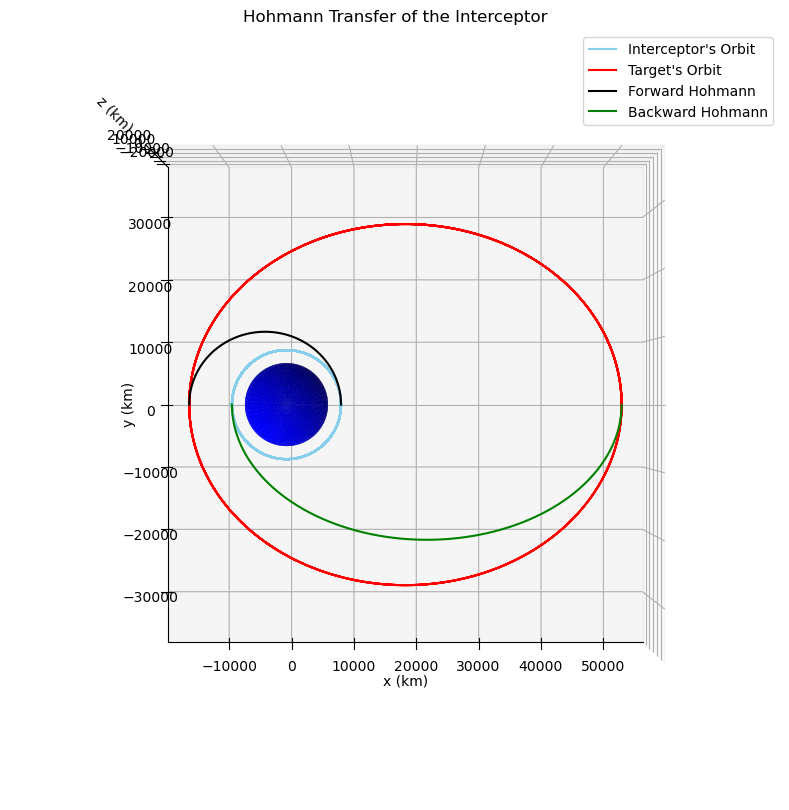

In [ ]:
# Import the required packages
import matplotlib.pyplot as plt
import numpy as np
from space_base import GravBody, Probe 

# Define the physical constants in S.I. unit
G = 6.67e-11
earth = GravBody.earth()
mu = G * earth.mass

# Define the atmosphere model
def atmosphere(posvel):
    r = np.linalg.norm(posvel[0:3])
    h = r - earth.radius
    surface_dens = earth.surface_density
    scale_height = earth.scale_height
    density = surface_dens * np.exp(- h / scale_height)
    return density

# Define the gravitational field model
def gravplanetearth(posvel):
    r = np.linalg.norm(posvel[0:3])
    f = - mu / r ** 3
    return (f * posvel[0], f * posvel[1], f * posvel[2])

# Define the equation of motion for the spacecraft
def probeqnsearth(t, posvel):
    cd=1.
    A=0.01
    mass=1.

    density = atmosphere(posvel)
    current_gravity = gravplanetearth(posvel)
    v_norm = np.linalg.norm(np.array(posvel[3:6]))
    drag = - 0.5 * cd * A * density * v_norm * np.array(posvel[3:6]) / mass
    
    posveldot = posvel[3], posvel[4], posvel[5], \
        current_gravity[0] + drag[0], current_gravity[1] + drag[1], current_gravity[2] + drag[2]
    
    return posveldot

# Time settings
t_final = 3600 * 60
t_num = 5000

# Initial Conditions for the interceptor
r_i = earth.radius + 2000e3
v_i = np.sqrt(mu / r_i) # Initial velocity vy0
print(f"Interceptor v_init: {v_i:.3f} m/s.")

x0_i = r_i
y0_i = 0 
z0_i = 0

vx0_i = 0
vy0_i = v_i
vz0_i = 0

# Plotting
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

interceptor = Probe(probeqnsearth, t_final, t_num, x0=x0_i, vx0=vx0_i,
            y0=y0_i, vy0=vy0_i, z0=z0_i, vz0=vz0_i, event=earth.radius)  # probe as an object
t, posvel_i = interceptor.odesolve()  # solve the differential equations
ax.plot(posvel_i[:, 0] / 1e3, posvel_i[:, 1] / 1e3, color='skyblue', label="Interceptor's Orbit")  # plot the interceptor

# Initial Conditions for the target
a_t = (earth.radius + 60000e3) / 2
e_t = 0.55
r_a_t = a_t * (1 + e_t)
r_p_t = a_t * (1 - e_t)

vy_t = np.sqrt(mu * (2 / r_a_t - 1 / a_t))
print(f"vy_target at r_a: {vy_t:.3f} m/s.\n")

x0_t = r_a_t
y0_t = 0 
z0_t = 0

vx0_t = 0
vy0_t = vy_t
vz0_t = 0

target = Probe(probeqnsearth, t_final, t_num, x0=x0_t, vx0=vx0_t,
            y0=y0_t, vy0=vy0_t, z0=z0_t, vz0=vz0_t, event=earth.radius)  
t_target, posvel_target = target.odesolve()
ax.plot(posvel_target[:, 0] / 1e3, posvel_target[:, 1] / 1e3, color='red', label="Target's Orbit")  # plot the target

# Parameters for the 1st Hohmann transfer
a_transfer_1 = (r_i + r_p_t) / 2
T_transfer_1 = np.sqrt(4 * (np.pi)**2  * a_transfer_1**3 / mu)

takeoff_burn_1 = np.sqrt(mu * (2 / r_i - 1 / a_transfer_1))
arrival_burn_1 = np.sqrt(mu * (2 / r_p_t - 1 / a_transfer_1))

print(f"Transfer 1: Takes {T_transfer_1 / 2 / 60:.3f} mins from the interceptor to the target.")
print(f"Take-off velocity: {takeoff_burn_1:.3f} m/s.")
print(f"Arrival burn: {arrival_burn_1:.3f} m/s.\n")

# Plot the forward Hohmann transfer
x0 = r_i
y0 = 0 
z0 = 0

vx0 = 0
vy0 = takeoff_burn_1
vz0 = 0

# Plotting
transfer_1 = Probe(probeqnsearth, T_transfer_1 / 2, t_num, x0=x0, vx0=vx0,
            y0=y0, vy0=vy0, z0=z0, vz0=vz0, event=earth.radius)  
t, posvel_transfer_1 = transfer_1.odesolve()
ax.plot(posvel_transfer_1[:, 0] / 1e3, posvel_transfer_1[:, 1] / 1e3, color='black', label='Forward Hohmann') # plot the transfer orbit

# Parameters for the backwards Hohmann transfer
a_transfer_2 = (r_i + r_a_t) / 2
T_transfer_2 = np.sqrt(4 * (np.pi)**2  * a_transfer_2**3 / mu)

takeoff_burn_2 = np.sqrt(mu * (2 / r_i - 1 / a_transfer_2))
arrival_burn_2 = np.sqrt(mu * (2 / r_a_t - 1 / a_transfer_2))

print(f"Transfer 2: Takes {T_transfer_2 / 2 / 60:.3f} mins from the interceptor to the target.")
print(f"Take-off velocity: {takeoff_burn_2:.3f} m/s.")
print(f"Arrival burn: {arrival_burn_2:.3f} m/s.")

# Plot the backwards Hohmann transfer
x0 = - r_i
y0 = 0 
z0 = 0

vx0 = 0
vy0 = - takeoff_burn_2
vz0 = 0
transfer_2 = Probe(probeqnsearth, T_transfer_2 / 2, t_num, x0=x0, vx0=vx0,
            y0=y0, vy0=vy0, z0=z0, vz0=vz0, event=earth.radius)  

# Plotting
t, posvel_transfer_2 = transfer_2.odesolve()
ax.plot(posvel_transfer_2[:, 0] / 1e3, posvel_transfer_2[:, 1] / 1e3, color='green', label='Backward Hohmann')

# Plotting Earth
uang = np.linspace(0, 2 * np.pi, 100)
vang = np.linspace(0, np.pi, 100)
x = earth.radius / 1e3 * np.outer(np.cos(uang), np.sin(vang))
y = earth.radius / 1e3 * np.outer(np.sin(uang), np.sin(vang))
z = earth.radius / 1e3 * np.outer(np.ones(np.size(uang)), np.cos(vang))

ax.plot_surface(x, y, z, color='blue')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('z (km)')
ax.azim = -90
ax.elev = 90

plt.axis('Equal')
plt.title('Hohmann Transfer of the Interceptor')
plt.legend()

plt.savefig('Fig. 4c Hohmann_transfer.png', dpi=300)

plt.show()

- Define the Cost & Gradient Descent Function

In [ ]:
# Time settings
t_final = 3600 * 24

# Define the cost function J
def cost_function2D(v, theta, lambda_penalty=1e-3, v_i=v_i, r_p_t=r_p_t, r_a_t=r_a_t):
   """A 2D cost function based on the first, second burns and the transfer time.
   J = delta v1 + delta v2 + lambda * t_transfer

   Parameters
   ----------
   v: float
      v (m/s) value.
   theta: float
      Theta value.
   lambda_penalty: float, optional
      Lagrange multiplier or penalty factor. Default is 1e-3.
   v_i: float, optional
      Initial velocity of the interceptor.
   r_p_t: float, optional
      Periapsis of the target. Default is 14933.475 (km).
   r_a_t: float, optional
      Apoapsis of the target. Default is 51437.525 (km).

   Returns
   -------
   J: tuple
      Total cost.
   posvel_i: ndarray 
      Position and velocity values over time in x, y & z planes.
   t_transfer: float
      Transfer time to the target's orbit.
   (first_burn, second_burn): tuple
      delta v1, delta v2 in the cost.
   """
   first_burn = abs(v - v_i)
   delta_v_val = v - v_i  # allowed to be negative (retrograde burn)
      
   vx0 = delta_v_val * np.sin(theta)
   vy0 = v_i + delta_v_val * np.cos(theta) 
   vz0 = 0

   # Run the interceptor transfer
   transfer = Probe(probeqnsearth, t_final, t_num, x0=x0_i, vx0=vx0,
               y0=y0_i, vy0=vy0, z0=z0_i, vz0=vz0)  
   t, posvel_i = transfer.odesolve()

   radii_int = np.linalg.norm(posvel_i[:, :3], axis=1)

   # Interceptor stops as soon as it hits the target's orbit
   condition = (radii_int >= r_p_t) & (radii_int <= r_a_t)
   if np.any(condition):
      idx = np.nonzero(condition)[0][0]
      t_transfer = t[idx]
   else:
      t_transfer = t[-1]

   if np.any(condition):
      v_int_vector = posvel_i[idx, 3:6]
      r_int = radii_int[idx]
   else:
      v_int_vector = posvel_i[-1, 3:6]
      r_int = radii_int[-1]

   # Find the target's velocity using energy conservation
   v_target = np.sqrt(mu * (2.0 / r_int - 1.0 / a_t))

   # Compute the difference in velocity vector
   v_target_vector = v_target * np.array([-np.sin(theta), np.cos(theta), 0])
   
   second_burn = np.linalg.norm(v_int_vector - v_target_vector)
   
   # Compute the cost J
   J = first_burn + second_burn + lambda_penalty * t_transfer

   return J, posvel_i, t_transfer, (first_burn, second_burn)

# Define the gradient descent model
def gradient_descent2D(
    v_init, theta_init, delta_v=0.5, delta_theta=np.radians(0.5), lambda_penalty=1e-3, 
    max_iter=50, tol=1e-8, eta_v=0.5, eta_theta=1e-6, sub_steps=5
):
   """Automated gradient descent pipeline on (v, theta) based on 'cost_function2D'.
    
   Parameters
   ----------
   v_init: float; theta_init: float
         Initial guesses for v (m/s) and theta.
   delta_v, delta_theta: float, optional
         Finite-difference steps for v and theta. Defaults are 0.5 and np.radians(0.5).
   lambda_penalty: float, optional
         Lagrange multiplier or penalty factor. Default is 1e-3.
   max_iter: int, optional
         Max. no. of iterations. Default is 50.
   tol: float, optional
         Stopping threshold for parameter changes. Default is 1e-8.
   eta_v,  eta_theta : float, optional                        
         Learning rate for v and theta. Defaults are 0.5 and 1e-6.
   sub_steps: int, optional                      
         No. of sub-steps for mini updates. Default is 5.
    
   Returns
   -------
   (v, theta): tuple
               Final optimised parameters.
   [params_history]: ndarray 
               (v, theta) per iteration.
   [cost_history]: ndarray
               Cost values per iteration.
   """
   v = float(v_init)
   theta = float(theta_init)
   params_history = []
   cost_history = []
   
   def numeric_gradient(v_val, theta_val, lambda_penalty):
      """Compute the partial derivatives of the cost function w.r.t. v and theta.
       
      Parameters
      ----------
      v_val: float
         v (m/s) value.
      theta_val: float
         Theta value.
      lambda_penalty: float
         Lagrange multiplier or penalty factor.
   
      Returns
      -------
      [grad_v, grad_theta]: ndarray
                            List of gradient values for v and theta.
      """
      # Partial derivative wrt v
      J_plus_v, _, _, _  = cost_function2D(v_val + delta_v, theta_val, lambda_penalty)
      J_minus_v, _, _, _ = cost_function2D(v_val - delta_v, theta_val, lambda_penalty)
      grad_v = (J_plus_v - J_minus_v) / (2.0 * delta_v)
      
      # Partial derivative wrt theta
      J_plus_theta, _, _, _ = cost_function2D(v_val, theta_val + delta_theta, lambda_penalty)
      J_minus_theta, _, _, _= cost_function2D(v_val, theta_val - delta_theta, lambda_penalty)
      grad_theta = (J_plus_theta - J_minus_theta) / (2.0 * delta_theta)
      
      return np.array([grad_v, grad_theta])
   
   for iteration in range(1, max_iter + 1):
      # Compute the gradient at the current (v, theta)
      grad_v, grad_t = numeric_gradient(v, theta, lambda_penalty)

      # Split the update into sub-steps
      dv = (eta_v / sub_steps) * grad_v
      dt = (eta_theta / sub_steps) * grad_t

      for _ in range(sub_steps):
         # Do a small update
         v_new = v - dv
         theta_new = theta - dt

         # clamp v >= 7809 m/s, clamp theta in [0, 90 deg]
         v_new = max(v_new, 7809.0)
         theta_new = np.clip(theta_new, 0, np.radians(90))

         v, theta = v_new, theta_new
         
      # Evaluate cost
      J_current, _, _, _ = cost_function2D(v, theta, lambda_penalty)
      
      cost_history.append(J_current)
      params_history.append([v, theta])
      
      # Halt if both updates are sufficiently small
      if (abs(dv*sub_steps) < tol) and (abs(dt*sub_steps) < tol):
         print(f"Convergence at iteration {iteration}")
         break
   
   return (v, theta), np.array(params_history), np.array(cost_history)

- Plot Cost Function J vs. Iteration 

Optimised v: 9376.189 m/s.
Optimised theta: 35.513 degrees.
Optimised cost: 2609.422.


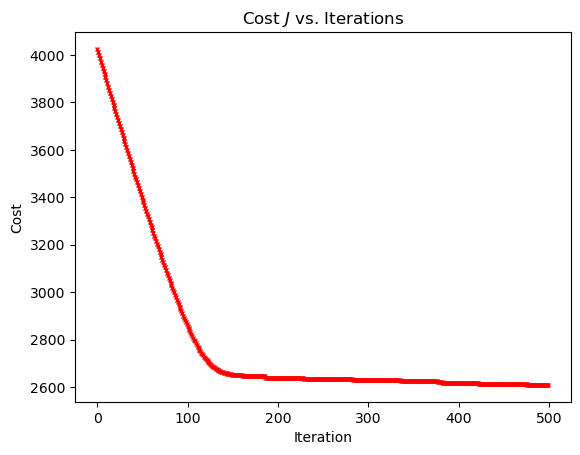

In [ ]:
# Time settings
t_final = 3600 * 24  # simulation time

# Minimum burn needs to be > 911 m/s to escape the elliptical transfer
# So the test values for v would be > 7809 (~ 8000) m/s
v_init = 9300.0
theta_init = np.radians(25)

# Hyperparameters for tuning 
common_lambda = 1e-3
tol = 1e-5 # 1e-5 ~ 1e-8 (BEST: 1e-5)
eta_v = 0.2 # 1e-2 ~ 1 (BEST: 0.2)
eta_theta = 2 * 1e-7 # 1e-6 ~ 1e-7 (BEST: 2 * 1e-7)
delta_v = 0.5
delta_theta = np.radians(0.01) # 0.1 ~ 0.01 (BEST: 0.01)
max_iter = 500
sub_steps = 20 # 5 ~ 20

# Run gradient descent from the initial guess
(v_optimal, theta_optimal), params_history, cost_history = gradient_descent2D(
    v_init, theta_init, delta_v=delta_v, delta_theta=delta_theta, 
    lambda_penalty=common_lambda, max_iter=max_iter, tol=tol, 
    eta_v=eta_v, eta_theta=eta_theta, sub_steps=sub_steps
)

print(f"Optimised v: {v_optimal:.3f} m/s.")
print(f"Optimised theta: {np.degrees(theta_optimal):.3f} degrees.")
print(f"Optimised cost: {cost_history[-1]:.3f}.")

# Plot the cost function J vs. iteration
iters = range(len(cost_history))

plt.figure()
plt.plot(iters, cost_history, 'x-', color='red', markersize=3)
plt.title(r"Cost $J$ vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.savefig('Fig. 4d Cost_vs._Iteration.png', dpi=300)

plt.show()

- Visualise the Parameter Grid Using a Contour Surface Plot

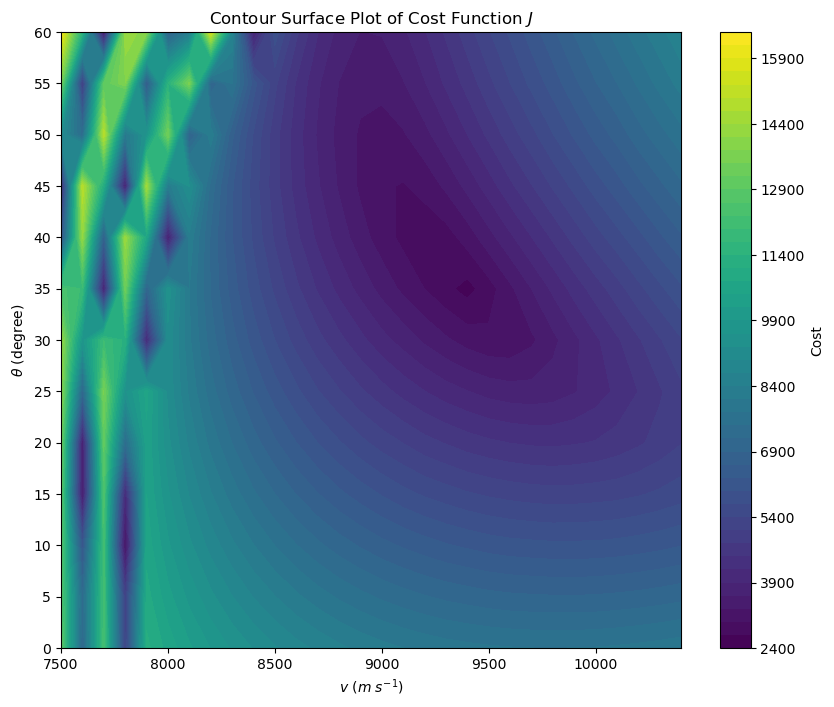

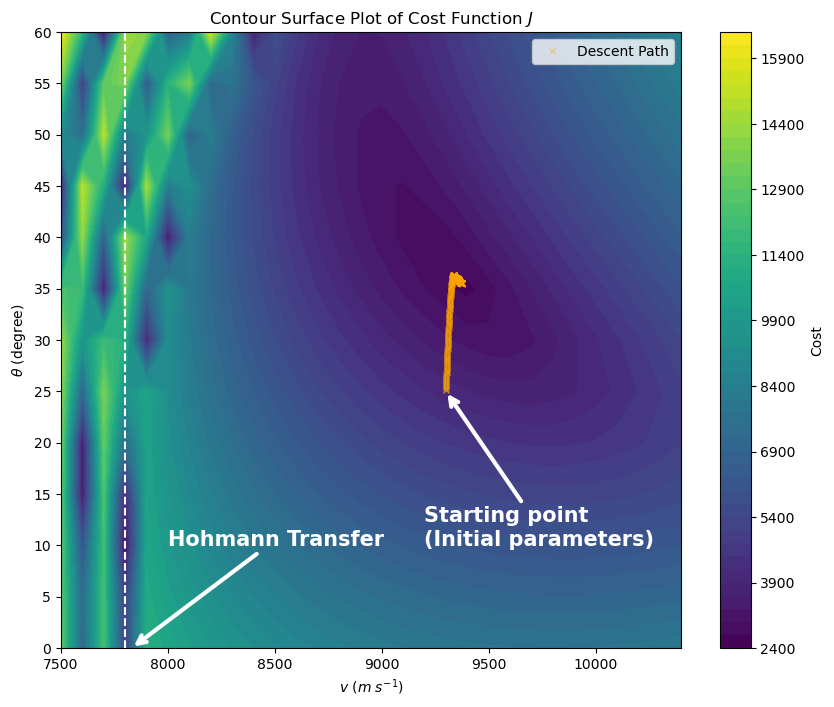

In [ ]:
# Time settings
t_final = 3600 * 24

# Define ranges of v and theta for plotting
v_start = 7500
v_end = 10500
x_ticks = np.arange(v_start, v_end, 500)
y_ticks = np.arange(0, 65, 5)

vs = np.arange(v_start, v_end, 100)
thetas = np.arange(0, np.radians(65), np.radians(5))

# Map v and theta values into a meshgrid
V, T = np.meshgrid(vs, thetas)
cost_vals = np.zeros_like(V)

# Compute cost for each point in the grid
for i in range(V.shape[0]):
    for j in range(V.shape[1]):
        cost_vals[i, j], _, _, _ = cost_function2D(V[i, j], T[i, j])

# Plot the reference contour map
plt.figure(figsize=(10, 8))
cp = plt.contourf(V, np.degrees(T), cost_vals, levels=50, cmap='viridis')
plt.colorbar(cp, label='Cost')
plt.xlabel(r'$v$ ($m$ $s^{-1}$)')
plt.ylabel(r'$\theta$ (degree)')
plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.title(r'Contour Surface Plot of Cost Function $J$')
plt.show()

# Plot the actual contour map
plt.figure(figsize=(10, 8))

cp = plt.contourf(V, np.degrees(T), cost_vals, levels=50, cmap='viridis')
plt.colorbar(cp, label='Cost')
plt.xlabel(r'$v$ ($m$ $s^{-1}$)')
plt.ylabel(r'$\theta$ (degree)')
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.axvline(7800, linestyle='--', c='white')

plt.title(r'Contour Surface Plot of Cost Function $J$')

params_history = np.array(params_history)

plt.plot(params_history[:, 0], np.degrees(params_history[:, 1]),
         'x', label='Descent Path', color='orange', linewidth=3, alpha=0.4, markersize=5)

# Annotate the Hohmann transfer
plt.annotate(text='Hohmann Transfer', xy=(7830, 0), xytext=(8000, 10),
             arrowprops={'arrowstyle': '->', 'color': 'white', 'linewidth': 3}, c='white', fontsize=15, fontweight='bold')

# Annotate the optimised transfer
plt.annotate(text='Starting point\n(Initial parameters)', xy=(v_init, 25), xytext=(9200, 10),
             arrowprops={'arrowstyle': '->', 'color': 'white', 'linewidth': 3}, c='white', fontsize=15, fontweight='bold')
plt.legend()

plt.savefig('Fig. 4e Contour.png', dpi=300)

plt.show()

- Animation of the Gradient Descent

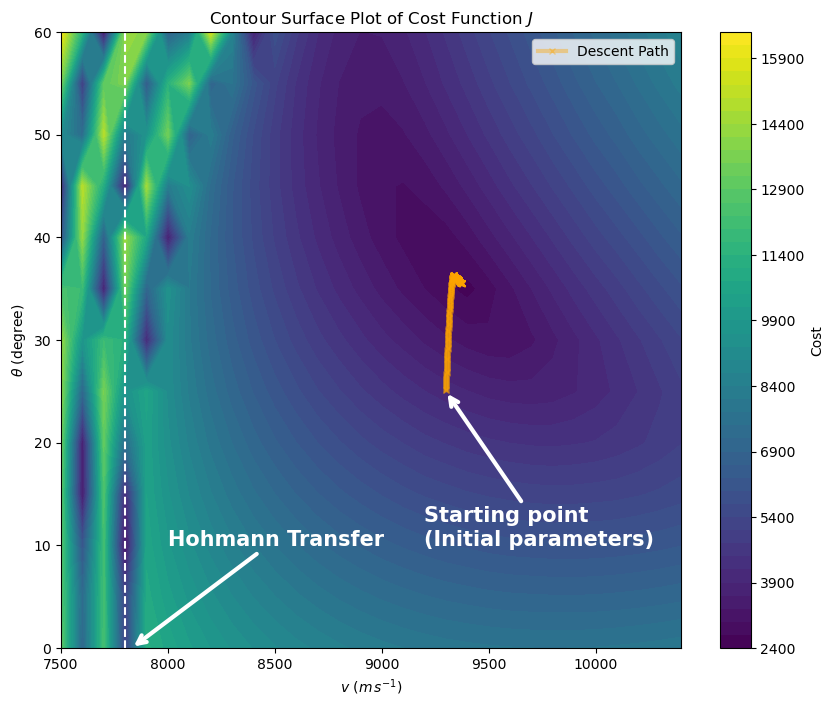

In [ ]:
# Import additional packages for animation
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the contour
cp = ax.contourf(V, np.degrees(T), cost_vals, levels=50, cmap='viridis')
cbar = plt.colorbar(cp, ax=ax)
cbar.set_label('Cost')
ax.set_xlabel(r'$v$ ($m \, s^{-1}$)')
ax.set_ylabel(r'$\theta$ (degree)')
ax.set_title(r'Contour Surface Plot of Cost Function $J$')
ax.axvline(7800, linestyle='--', c='white')

# Annotations
ax.annotate(text='Hohmann Transfer', xy=(7830, 0), xytext=(8000, 10),
             arrowprops={'arrowstyle': '->', 'color': 'white', 'linewidth': 3}, c='white', fontsize=15, fontweight='bold')
ax.annotate(text='Starting point\n(Initial parameters)', xy=(v_init, 25), xytext=(9200, 10),
             arrowprops={'arrowstyle': '->', 'color': 'white', 'linewidth': 3}, c='white', fontsize=15, fontweight='bold')

# Plot the descent path
params_history = np.array(params_history)

# Create the animation
line, = ax.plot([], [], 'x-', lw=3, markersize=5, alpha=0.4, label='Descent Path', color='orange')
ax.legend()

# Define a function to instantiate the animation data
def init():
    line.set_data([], [])
    return (line,)

# Define the animation function
def animate(i):
    data = params_history[:i+1, :]
    v_vals = data[:, 0]
    theta_vals = np.degrees(data[:, 1])
    line.set_data(v_vals, theta_vals)
    return (line,)

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(params_history), init_func=init,
                              interval=200, blit=True, repeat=False)

# Set the customised FFmpeg path
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Users\tseng\OneDrive\桌面\ffmpeg-2025-03-31-git-35c091f4b7-full_build\bin\ffmpeg.exe'

# Customise the settings
writer = FFMpegWriter(
    fps=30, 
    metadata={'artist': 'Tszon Tseng', 'title': 'Gradient Descent Animation'},
    bitrate=1800
)
ani.save('gradient_descent_mp4.mp4', writer=writer, dpi=300)

plt.show()

In [12]:
print(animation.writers.list())

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


- Plot the guess and optimised transfers

Time required with initial params:
9300.000 m/s, 25.000 degrees,
1st burn: 2401.710 m/s, 2nd burn: 1634.662 m/s
would be 33.991 mins.

Time required for the optimised transfer:
9376.189 m/s, 35.513 degrees,
1st burn: 2477.899 m/s, 2nd burn: 129.518 m/s
would be 33.415 mins.


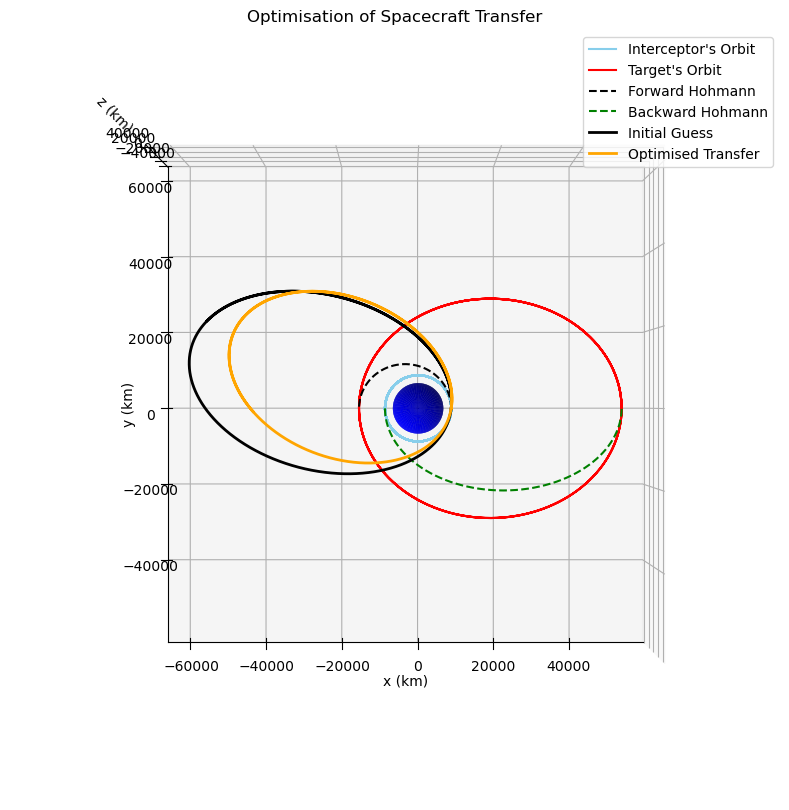

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the interceptor and the target
ax.plot(posvel_i[:, 0] / 1e3, posvel_i[:, 1] / 1e3, color='skyblue', label="Interceptor's Orbit")  
ax.plot(posvel_target[:, 0] / 1e3, posvel_target[:, 1] / 1e3, color='red', label="Target's Orbit")

# Plot the forward and backwards Hohmann transfers
ax.plot(posvel_transfer_1[:, 0] / 1e3, posvel_transfer_1[:, 1] / 1e3, color='black', linestyle='--', label='Forward Hohmann')
ax.plot(posvel_transfer_2[:, 0] / 1e3, posvel_transfer_2[:, 1] / 1e3, color='green', linestyle='--', label='Backward Hohmann')

# Plot the transfer for the initial guess
_ , posvel_guess, t_guess, (firstburn_guess, arrivalburn_guess) = cost_function2D(v_init, theta_init)
ax.plot(posvel_guess[:, 0] / 1e3, posvel_guess[:, 1] / 1e3, color='black', linewidth=2, label='Initial Guess')
print(f"Time required with initial params:\n{v_init:.3f} m/s, {np.degrees(theta_init):.3f} degrees,\n1st burn: {firstburn_guess:.3f} m/s, 2nd burn: {arrivalburn_guess:.3f} m/s\nwould be {t_guess / 60:.3f} mins.\n")

optimal_v = params_history[-1][0]
optimal_theta = params_history[-1][1]

# Plot the optimised transfer
_ , posvel_opt, t_optimal, (firstburn_optimal, arrivalburn_optimal) = cost_function2D(optimal_v, optimal_theta, lambda_penalty=common_lambda)
ax.plot(posvel_opt[:, 0] / 1e3, posvel_opt[:, 1] / 1e3, color='orange', linewidth=2, label='Optimised Transfer')
print(f"Time required for the optimised transfer:\n{optimal_v:.3f} m/s, {np.degrees(optimal_theta):.3f} degrees,\n1st burn: {firstburn_optimal:.3f} m/s, 2nd burn: {arrivalburn_optimal:.3f} m/s\nwould be {t_optimal / 60:.3f} mins.")

# Plot the Earth
ax.plot_surface(x, y, z, color='blue')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('z (km)')
ax.azim = -90
ax.elev = 90

plt.axis('Equal')
plt.title('Optimisation of Spacecraft Transfer')
plt.legend()

plt.savefig('Fig. 4f Optimised_transfer.png', dpi=300)

plt.show()

2. Evaluation of Uncertainties

In [ ]:
# Import the MCMC package
import emcee, corner

# Define the Boltzmann factor
sigma = 1.0 # Set to 1 for simplicity

# Define the likelihood function
def log_likelihood(params, sigma=sigma):
    v, theta = params
    J, _, _, _ = cost_function2D(v, theta)
    # Returns -ve infinity in case of missing values
    if np.isnan(J):
        return -np.inf
    return -J / (2 * sigma**2)

# Define the prior
def log_prior(params):
    v, theta = params
    if 7809.0 < v < 15000.0 and 0.0 <= theta <= np.radians(90):
        return 0.0
    # Returns -ve infinity for very high values of v and theta
    return -np.inf

# Define the log-probability
def log_prob(params, sigma=sigma):
    lp = log_prior(params)
    # Check if the log-probability is finite
    # Again, returns -ve infinity for very high values of v and theta
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, sigma)

# Run the MCMC sampler
initial = np.array([optimal_v, optimal_theta])
n_dim = 2 # no. of dimensions (or parameters)
n_walkers = 35 # no. of random walkers
n_iter = 300

# Define the random walkers
p0 = initial + 1e-2 * np.random.rand(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, args=(sigma,))
sampler.run_mcmc(p0, n_iter, progress=True)

samples = sampler.get_chain(discard=150, flat=True)

100%|██████████| 300/300 [04:34<00:00,  1.09it/s]


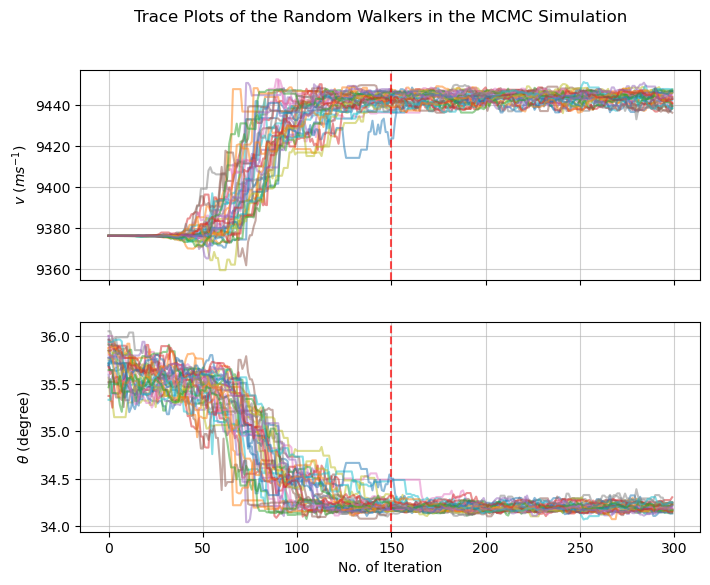

In [10]:
# Make trace plots
fig, axes = plt.subplots(2, figsize=(8, 6), sharex=True)

for i in range(n_walkers):
    axes[0].plot(sampler.chain[i, :, 0], alpha=0.5)
    axes[1].plot(np.degrees(sampler.chain[i, :, 1]), alpha=0.5)
axes[0].set_ylabel(r"$v$ $(ms^{-1})$")
axes[0].grid(visible=True, alpha=0.6)
axes[0].axvline(150, c='r', linestyle='--', alpha=0.7)

axes[1].set_ylabel(r"$\theta$ (degree)")
axes[1].set_xlabel("No. of Iteration")
axes[1].grid(visible=True, alpha=0.6)
axes[1].axvline(150, c='r', linestyle='--', alpha=0.7)

plt.suptitle("Trace Plots of the Random Walkers in the MCMC Simulation")
plt.savefig('Fig. 4g MCMC_traceplot.png', dpi=300)

plt.show()

- Animation of the Random Walkers

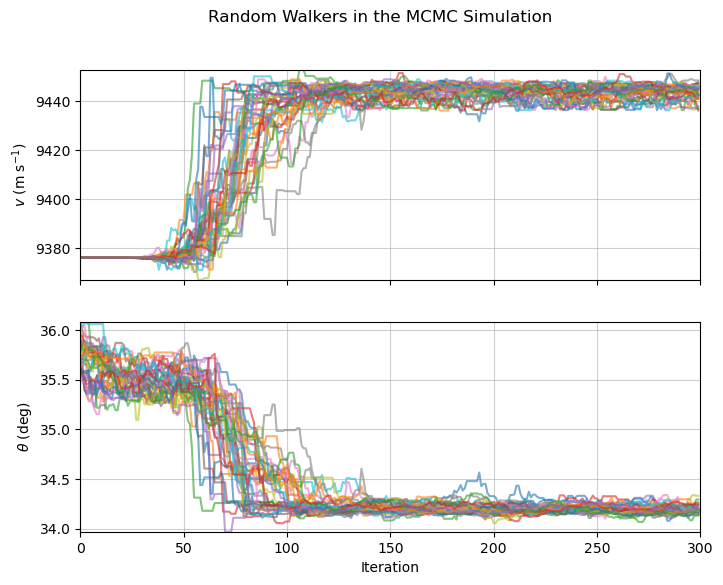

In [ ]:
samples = sampler.chain
# Unpack the dimensions of the chains  
n_walkers, n_iter, n_params = samples.shape

fig, axes = plt.subplots(2, figsize=(8, 6), sharex=True)

axes[0].set_ylabel(r"$v$ (m s$^{-1}$)")
axes[0].grid(visible=True, alpha=0.6)

axes[1].set_xlabel("Iteration")
axes[1].set_ylabel(r"$\theta$ (degree)")
axes[1].grid(visible=True, alpha=0.6)

plt.suptitle("Random Walkers in the MCMC Simulation")

# Instantiate empty lists for v and theta values
lines_v = []
lines_theta = []

for _ in range(n_walkers):
    (l_v,) = axes[0].plot([], [], alpha=0.6)
    (l_theta,) = axes[1].plot([], [], alpha=0.6)
    lines_v.append(l_v)
    lines_theta.append(l_theta)

# Define a function to instantiate the animation data
def init():
    for l_v, l_theta in zip(lines_v, lines_theta):
        l_v.set_data([], [])
        l_theta.set_data([], [])
    return lines_v + lines_theta

# Define the animation function
def animate(i):
    x = np.arange(i + 1)
    for j in range(n_walkers):
        y_v = samples[j, : i + 1, 0]
        y_theta = np.degrees(samples[j, : i + 1, 1])
        lines_v[j].set_data(x, y_v)
        lines_theta[j].set_data(x, y_theta)
    return lines_v + lines_theta

# Create the animation
ani = animation.FuncAnimation(
    fig, animate, frames=n_iter,
    init_func=init, interval=100, blit=False, repeat=False
)

mpl.rcParams['animation.ffmpeg_path'] = (
    r'C:\Users\tseng\OneDrive\桌面\ffmpeg-2025-03-31-git-35c091f4b7-full_build\bin\ffmpeg.exe'
)

writer = FFMpegWriter(fps=30, bitrate=1800)
ani.save('random_walkers_mp4.mp4', writer=writer, dpi=300)

plt.show()

In [39]:
print(sampler.chain.shape)

(35, 300, 2)


- Final results

In [22]:
v_vals_last = sampler.chain[:, -1, 0]
print(f'v values in the last iteration:\n{v_vals_last}\n')
print(f'Mean: {np.mean(v_vals_last):.3f} m/s\n')
print(f'Median: {np.median(v_vals_last):.3f} m/s\n')
print(f'Std: {np.std(v_vals_last):.3f} m/s\n')

print('---\n')

theta_vals_last = np.degrees(sampler.chain[:, -1, 1])
print(f'Theta values in the last iteration:\n{theta_vals_last}\n')
print(f'Mean: {np.mean(theta_vals_last):.3f} degrees\n')
print(f'Median: {np.median(theta_vals_last):.3f} degrees\n')
print(f'Std: {np.std(theta_vals_last):.3f} degrees\n')

v values in the last iteration:
[9437.47997815 9441.79021473 9446.29541842 9444.21854305 9439.95546573
 9444.24042048 9445.24414908 9440.48736061 9443.83401696 9448.32720959
 9447.08181092 9445.75087501 9438.18620271 9445.59239139 9445.41047249
 9446.3042622  9445.88620732 9445.53715103 9445.28687512 9443.83147101
 9447.40463894 9440.61449784 9447.58824542 9448.04543445 9442.57444434
 9444.74226279 9442.72492961 9446.79387483 9443.23569168 9445.47936252
 9440.15158892 9439.30860241 9440.15924015 9448.91072424 9437.51020494]

Mean: 9443.885 m/s

Median: 9444.742 m/s

Std: 3.162 m/s

---

Theta values in the last iteration:
[34.34468325 34.22460564 34.1737842  34.22267165 34.26913639 34.18852626
 34.18930484 34.2794575  34.15261504 34.12089585 34.16164652 34.15357824
 34.27777305 34.18629833 34.21682672 34.17473178 34.16637548 34.19256971
 34.18426874 34.17001254 34.14009363 34.25316652 34.12680458 34.12155606
 34.17206147 34.18940044 34.24438327 34.16899161 34.21595605 34.21448302
 34.3